# Modulation Mapper

**Goal:** Demonstrate the operation of the modulation mapper and the demodulator

**Steps:**

* We need a simple source and sink for producing a sequence of bits
* How do we describe a constellation?
* How do you implement the modulation mapper?
* What could go wrong? Noise!
* How can we recover the transmitted bits?

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

## A simple source

* For testing, we create a simple source of bits. 
* The source takes a string as an input and generates a vector of 0's and 1's.
* we accomplish this in two steps:
  + converting a string into a sequence of bytes
  + convert each byte into a sequence of 8 bits
* the bit sequence is obtained by concatenating all bits

We begin with converting a byte to 8 bits.

### Converting bytes to bits

* a byte can be viewed as
  + a number between 0 and 255
  + a sequence of 8 bits
  + both perspectives are equivalent
* Our goal is to extract the eight bits that make up the byte.
* We achieve that as follows:
  1. isolate the bit in the first (most significant position)
     - compute the `and` of the byte and the mask `1000 000` (decimal 128) 
  2. shift all bits by one position towards the MSB
     - computed using the bit-shift operation `<<`
     - this drops the bit that we just extracted
  3. repeat until we have all bits
 

In [9]:
def byte_to_bits(b):
    """convert a byte to a sequence of 8 bits"""
    
    # allocate memory for bits
    bits = np.zeros(8, dtype=np.uint8)
    
    # define the mask
    mask = 128
    
    for n in range(8):
        # extract the LSB and store it
        bits[n] = (b & mask) >> 7
        # shift the bits by one position
        b = b << 1
        
    return bits

In [13]:
# example: 
byte_to_bits(30)

array([0, 0, 0, 1, 1, 1, 1, 0], dtype=uint8)

### Converting a string to bits

* With this function in place, converting a string isn't very hard:

* loop over the bytes,
* convert each byte to bits,
* insert the resulting bits into a vector

In [56]:
def string_source(string):
    """convert a string to a vector of bits"""
    
    # convert a string to a sequence of bytes
    bb = string.encode()
    Nb = len(bb)
    
    # make space
    bits = np.zeros(8 * Nb, dtype=np.uint8)
    
    for n in range(Nb):
        bits[8*n : 8*(n+1)] = byte_to_bits(bb[n])
        
    return bits

In [57]:
# Example:
string_source("Hi")

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1], dtype=uint8)

## Modulation Mapper:

* A modulation mapper uses a look-up table to map groups of bits to symbols
* We use a `dict` to store this table:
  + the **keys** hold the group of bits
  + the **values** hold the symbols
* Here is a table for QPSK

In [31]:
QPSK = {
    0b00: 1,
    0b01: 1j,
    0b11: -1,
    0b10: -1j,
}

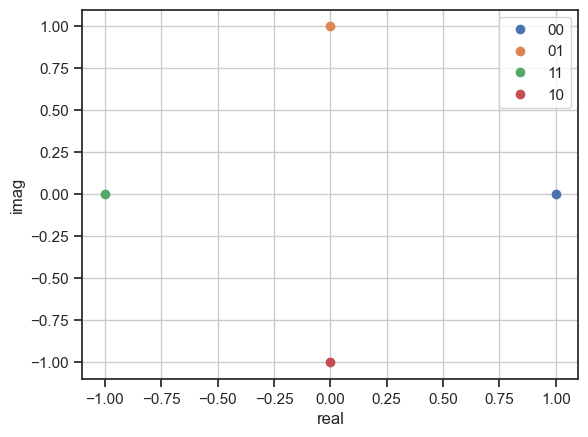

In [40]:
# plot the constellation
for k,v in QPSK.items():
    plt.plot(v.real, v.imag, 'o', label=f"{k:02b}")
    
plt.grid()
plt.xlabel('real')
plt.ylabel('imag')
plt.legend()

plt.show()

### Modulation Mapper Function

* a modulation mapper takes $\log_2(M)$ bits at a time and maps them to a symbol
  + first the bits are converted to a integer
* the lookup table is used to find the symbol that corresponds to the group of bits

In [45]:
def bits_to_int(bits):
    " convert a sequence of bits to an integer"
    res = 0 
    
    for b in bits:
        res = res << 1
        res = res + b
        
    return res

In [50]:
# Example:
bits_to_int([1, 1, 1, 1])

15

In [62]:
def mod_mapper(bits, mod_table):
    """map a sequence of bits to a sequence of symbols"""
    
    # how many bits per symbol?
    K = int( np.log2(len(mod_table)) )
    
    # how many symbols will we get?
    N = len(bits) // K
    syms = np.zeros(N, dtype=complex)
    
    for n in range(N):
        key = bits_to_int(bits[K*n : K*(n+1)])
        syms[n] = mod_table[key]
        
    return syms

In [66]:
bits = string_source('B')

bits, mod_mapper(bits, QPSK)